In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Classification analysis

In [2]:
import sys
sys.path.append('../visualization/')
from utils.cls_helpers import (
    compute_metrics, 
    plot_cls_metrics, 
    plot_relative_cls, 
    plot_relative_cls_summarization, 
    plot_cls_P_R,
    plot_distributions,
    plot_batch_times
    )

In [3]:
teacher = pd.read_csv('/home/st-aleksandr-razin/workspace/SRC_QC4QA/data/classified/teacher.csv', index_col=0)
student = pd.read_csv('/home/st-aleksandr-razin/workspace/SRC_QC4QA/data/classified/student.csv')

### Check Metrics for Full model

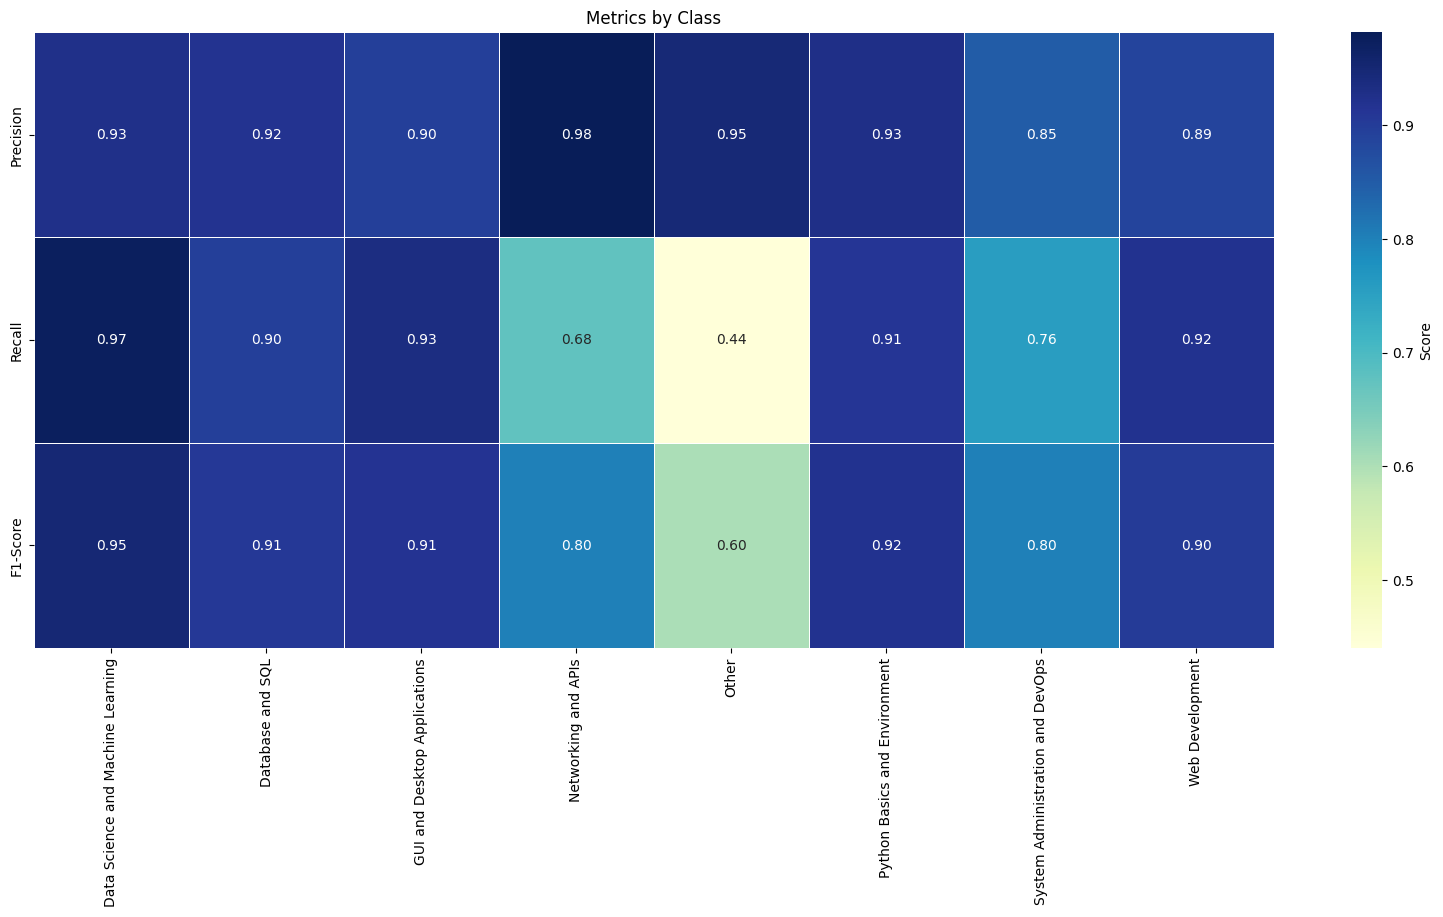

In [6]:
plot_cls_metrics(teacher)

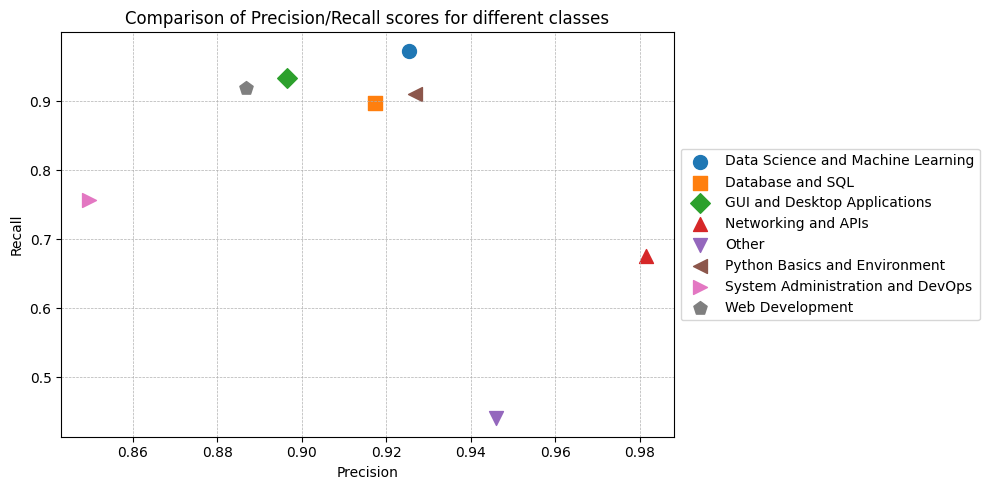

In [18]:
plot_cls_P_R(teacher)

### Check Metrics for Distilled model

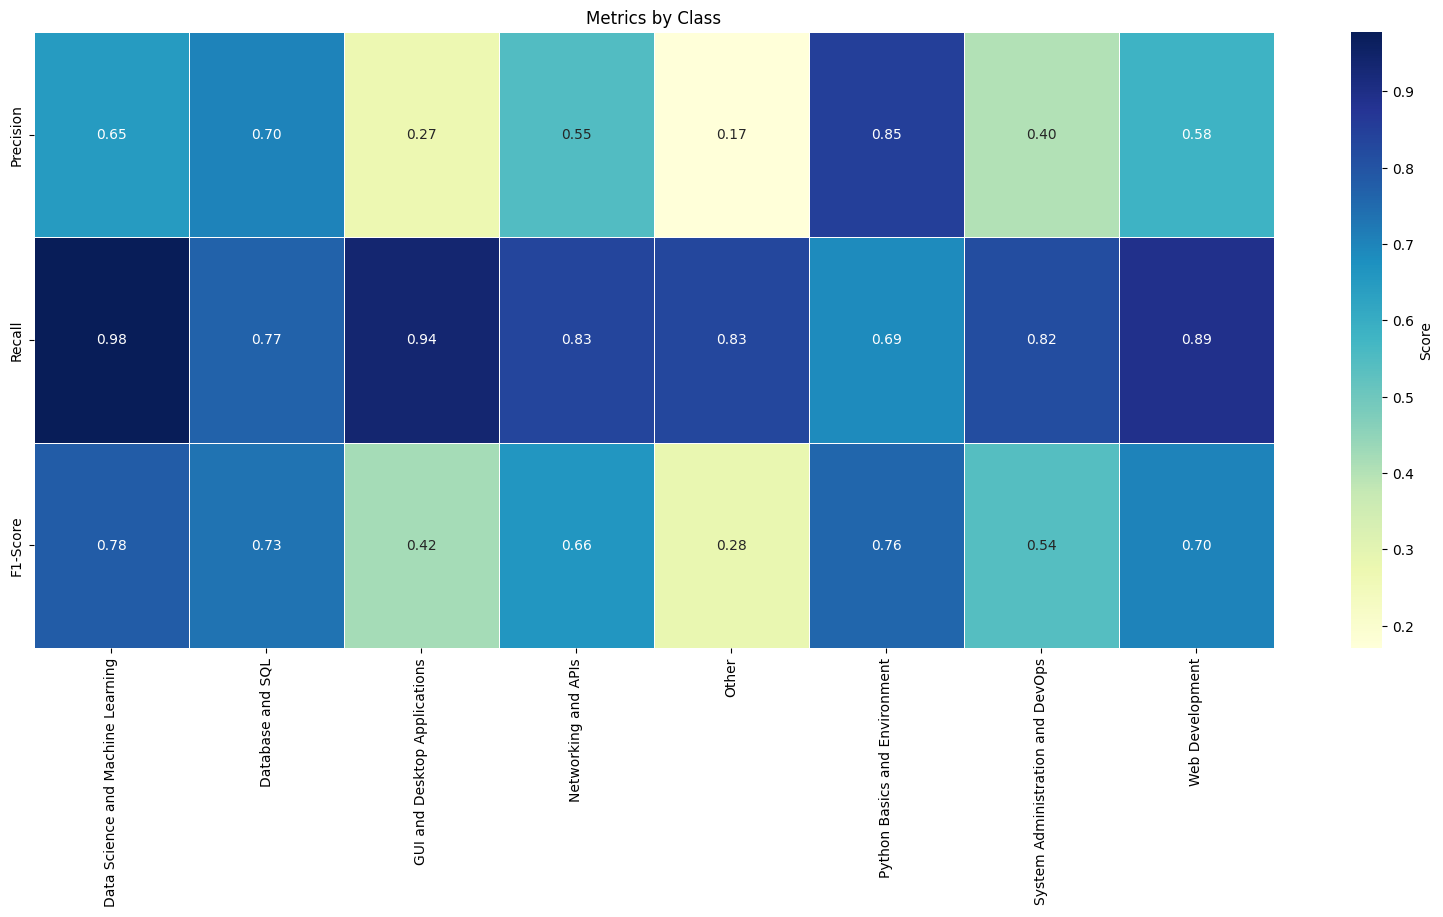

In [7]:
plot_cls_metrics(student)

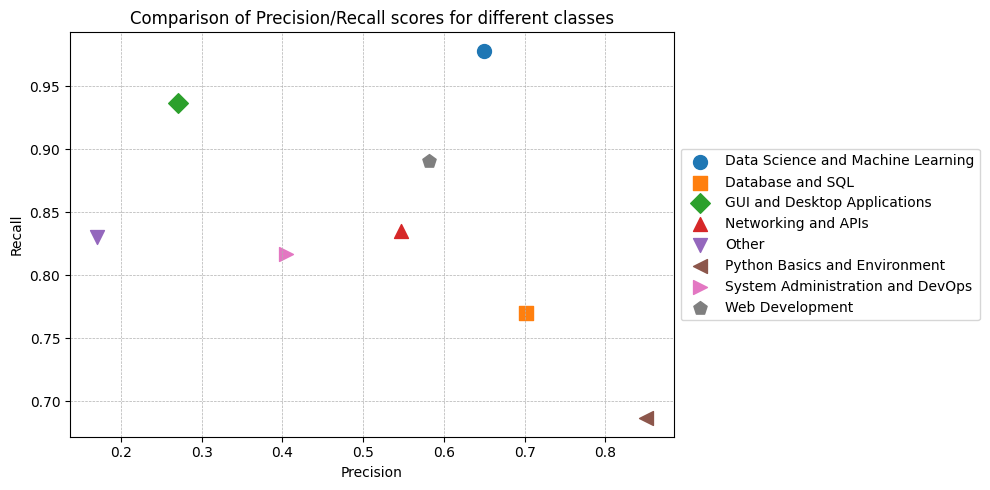

In [8]:
plot_cls_P_R(student)

### Check relative comparison for Distilled model and Full model metrics

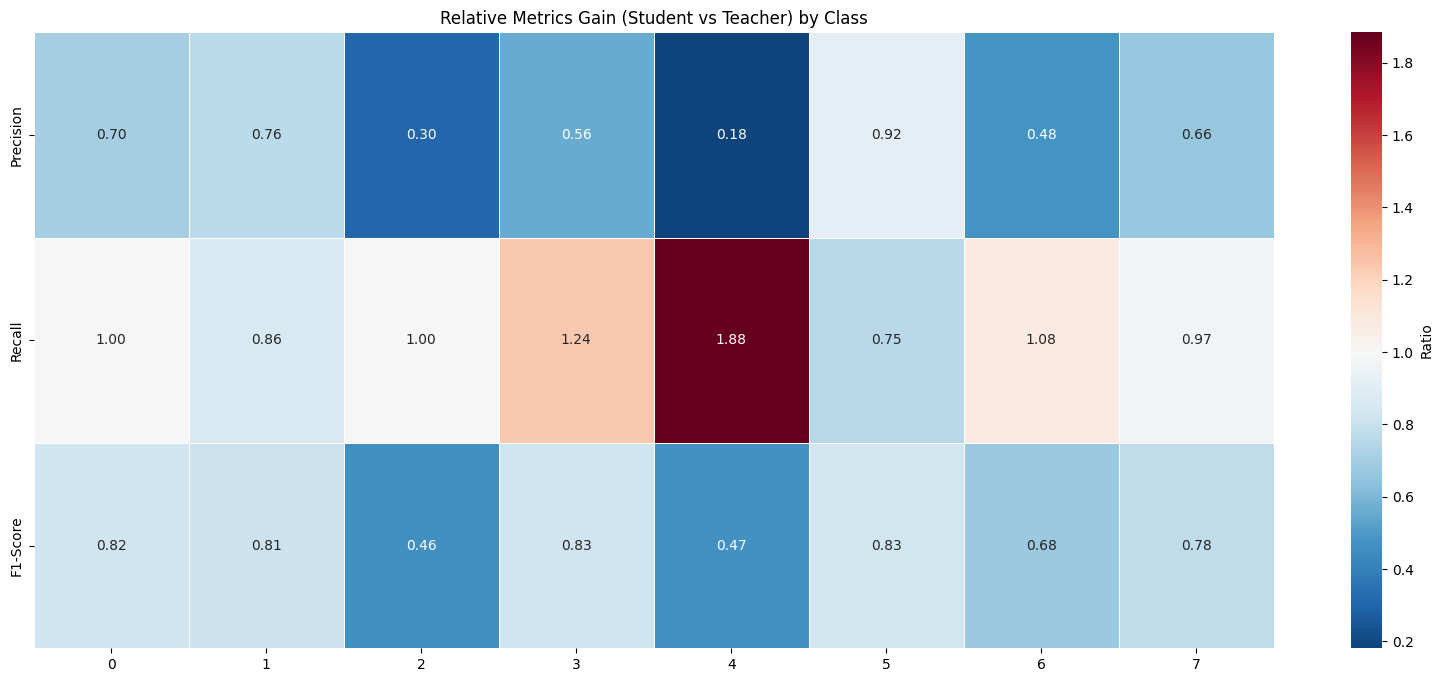

In [4]:
plot_relative_cls(teacher, student)

### Check Code summarization influence on CLS metrics

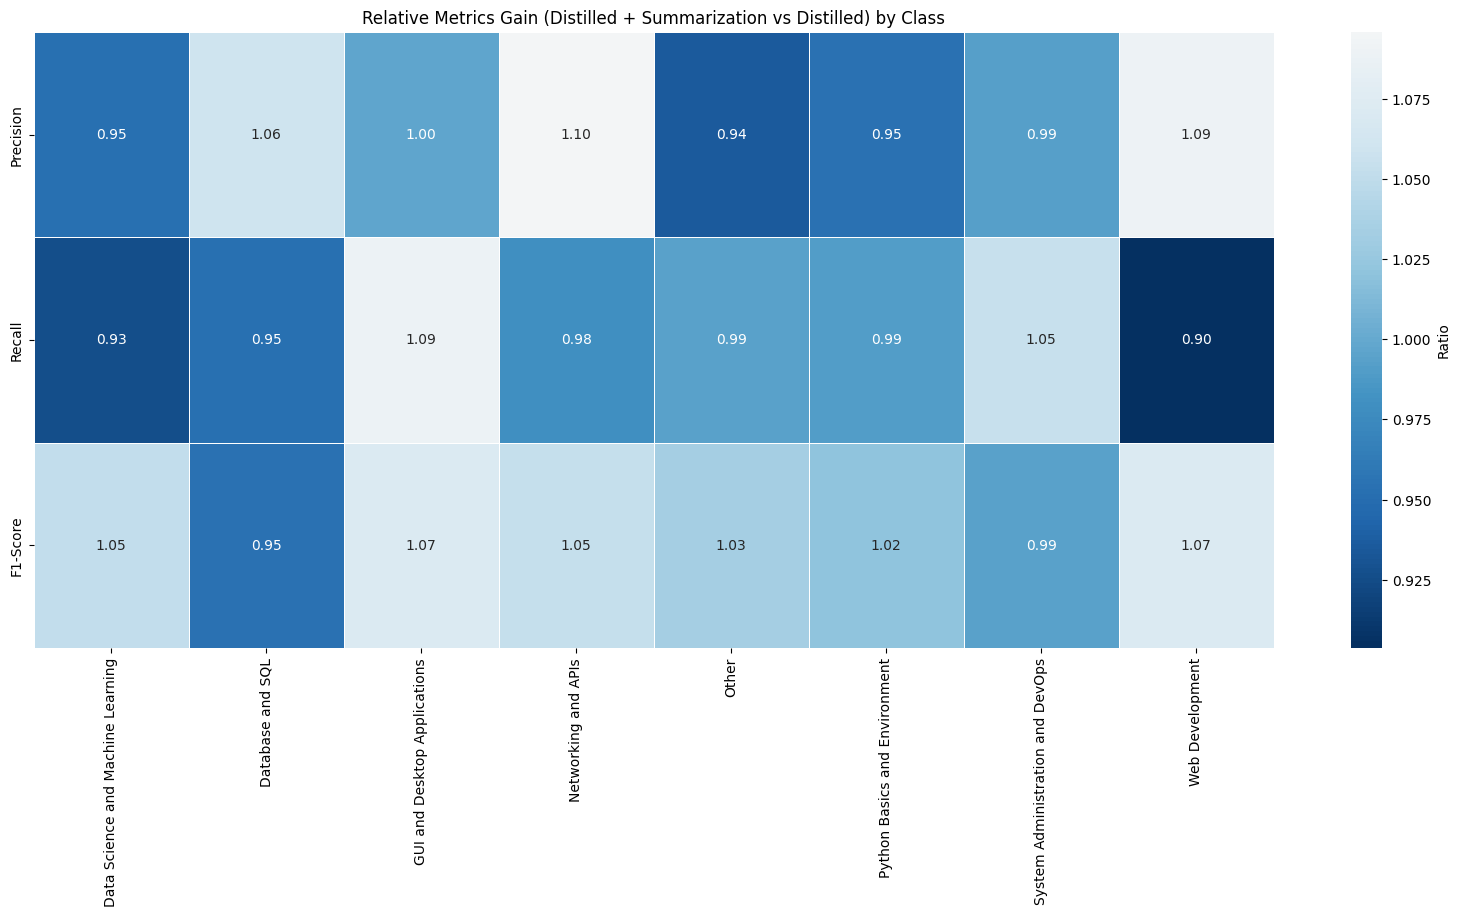

In [4]:
plot_relative_cls_summarization(student)

In [10]:
summarized = pd.read_csv('/home/st-aleksandr-razin/workspace/SRC_QC4QA/data/sample_for_t5_summarized.csv')
summarized

,Id_Q,Title_Q,Body_Q,Tags_Q,Code_Q,code_snippets
0,683,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,"['python', 'arrays', 'iteration']",True,"['foo in iter_attr(array of python objects, at..."
1,1171,What is the most efficient graph data structur...,<p>I need to be able to manipulate a large (10...,"['python', 'performance', 'data-structures', '...",True,"['graph[I][J][""Property""]=""value""\n']"
2,1476,How do you express binary literals in Python?,<p>How do you express an integer as a binary n...,"['python', 'syntax', 'binary', 'integer', 'lit...",True,"['>>> 0x12AF\n4783\n>>> 0x100\n256\n', '>>> 01..."
3,1829,How do I make a menu that does not require the...,<p>I've got a menu in Python. That part was ea...,['python'],True,"['raw_input()', 'raw_input', 'import sys\nprin..."
4,2311,File size differences after copying a file to ...,<p>I have created a PHP-script to update a web...,"['php', 'python', 'ftp', 'webserver', 'ftplib']",True,"['from ftplib import FTP\n\nftpserver = ""myser..."
...,...,...,...,...,...,...
95,146607,I'm using Python regexes in a criminally ineff...,<p>My goal here is to create a very simple tem...,"['regex', 'algorithm', 'optimization', 'python']",True,['def stripMatchedQuotes(item):\n MatchedSi...
96,147437,Difflib.SequenceMatcher isjunk optional parame...,<p>I am trying to use Difflib.SequenceMatcher ...,"['python', 'lambda', 'difflib']",True,"['s=difflib.SequenceMatcher(isjunk,text1,text2..."
97,147713,How do I manipulate bits in Python?,"<p>In C I could, for example, zero out bit #10...",['python'],True,['unsigned long value = 0xdeadbeef;\nvalue &= ...
98,148042,Using OR comparisons with IF statements,"<p>When using IF statements in Python, you hav...","['python', 'comparison', 'boolean']",True,"['if job == ""mechanic"" or job == ""tech"":\n ..."


In [23]:
summarized.iloc[0, -1]

"['foo in iter_attr(array of python objects, attribute name)']"

In [21]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration

In [22]:
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base-multi-sum')
model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base-multi-sum')

In [40]:
import sys
sys.path.append('../CodeSummarization/data')
from CodeDataset import CodeDataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm import tqdm

In [41]:
dataset = CodeDataset(summarized, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, collate_fn=DataCollatorWithPadding(tokenizer, padding=True))

descriptions = []
for batch in tqdm(dataloader):
    with torch.no_grad():
        generated_ids = model.generate(batch["input_ids"].to(device), max_length=20)
        descriptions.extend(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
        break

  0%|          | 0/25 [00:01<?, ?it/s]


In [44]:
for i in summarized.iloc[:4, -1]:
    print(i)

['foo in iter_attr(array of python objects, attribute name)']
['graph[I][J]["Property"]="value"\n']
['>>> 0x12AF\n4783\n>>> 0x100\n256\n', '>>> 01267\n695\n>>> 0100\n64\n', "int('01010101111',2)", '0b1100111', '0B1100111', '0o27', '0O27', '027']
['raw_input()', 'raw_input', 'import sys\nprint """Menu\n1) Say Foo\n2) Say Bar"""\nanswer = raw_input("Make a selection> ")\n\nif "1" in answer: print "foo"\nelif "2" in answer: print "bar"\n', 'print menu\nwhile lastKey = "":\n    lastKey = check_for_recent_keystrokes()\nif "1" in lastKey: #do stuff...\n']


In [42]:
descriptions

['Returns an array of objects with the name of the attribute name',
 'Sets the value of the property.',
 '0x12AF 0x12AF 0x4783 0x100 0x',
 'Display a user input to the user.']

### Check time comparison

In [5]:
student_times = pd.read_csv('/home/st-aleksandr-razin/workspace/SRC_QC4QA/data/classified/batch_inference_times_student.csv')
teacher_times = pd.read_csv('/home/st-aleksandr-razin/workspace/SRC_QC4QA/data/classified/batch_inference_times_teacher.csv')

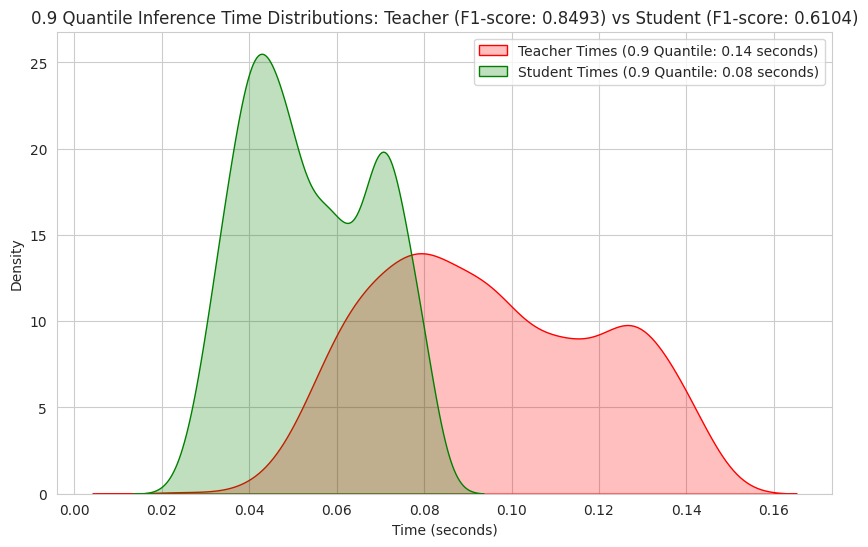

In [16]:
plot_distributions(
    teacher_times.values.squeeze(), 
    student_times.values.squeeze(), 
    round(np.mean(compute_metrics(teacher)['F1-Score']), 4), 
    round(np.mean(compute_metrics(student)['F1-Score']), 4)
    )

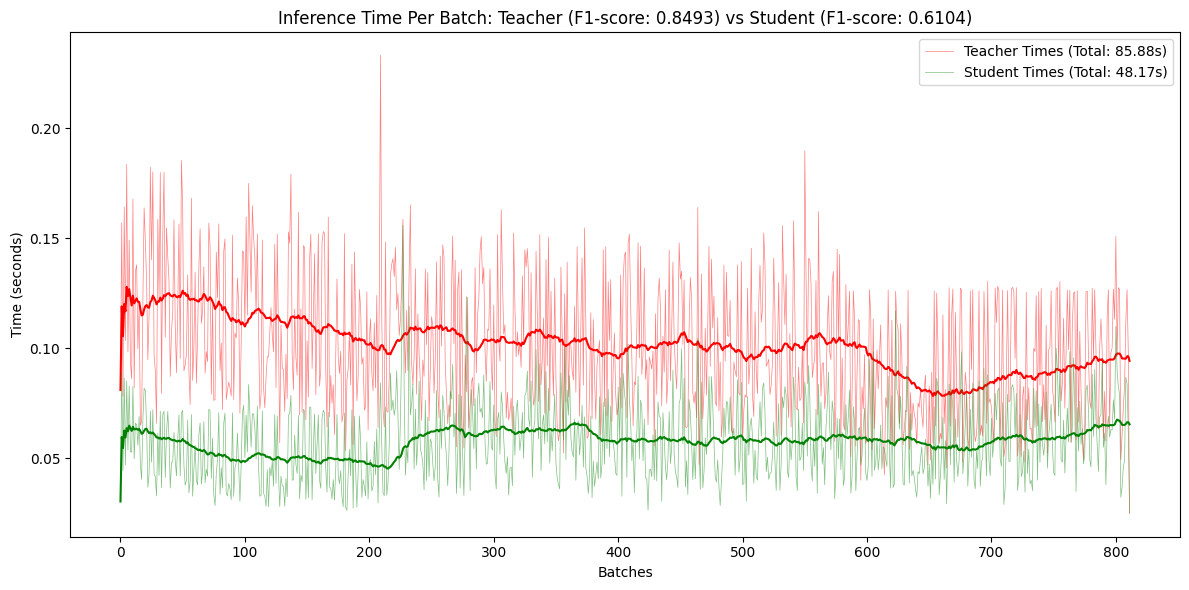

In [6]:
plot_batch_times(
    teacher_times.values.squeeze(), 
    student_times.values.squeeze(), 
    round(np.mean(compute_metrics(teacher)['F1-Score']), 4), 
    round(np.mean(compute_metrics(student)['F1-Score']), 4)
    )

# QA Analysis

In [1]:
import sys
sys.path.append('../visualization/')
from utils.qa_helpers import (
    compare_metrucs
    )

In [6]:
## Paths
path = '/home/st-aleksandr-razin/workspace/SRC_QC4QA/QA_pipeline/artifacts/tests/'

ds_adapter = 'Data_Science_and_Machine_Learning_class/test-256-0.8point-264_LoRa.csv'
ds_pretrain = 'Data_Science_and_Machine_Learning_class/test-256-0.8-llama-7b-hf-Lora-Data_Science_and_Machine_Learning_class-bs_16-lr_5e-05-m_l_1280-m_p_l_768-w_decay_0.2_base.csv'

sql_adapter = ''
sql_pretrain = 'databases_domain/test-LoRA_llama_filt_no_code-7b-max_prompt_length_768-databases_domain_base.csv'

app_adapter = 'GUI_Desktop_Applications_class/test-256-0.8point-285_LoRa.csv'
app_pretrain = 'GUI_Desktop_Applications_class/test-256-0.8-llama-7b-hf-Lora-GUI_Desktop_Applications-bs_16-lr_3e-05-m_l_768-m_p_l_512-w_decay_0.2_base.csv'

net_adapter = 'Networking_and_APIs_class/test-256-0.8point-152_LoRa.csv'
net_pretrain = 'Networking_and_APIs_class/test-256-0.8-llama-7b-hf-Lora-Networking_and_APIs-bs_16-lr_0.0001-m_l_1280-m_p_l_768-w_decay_0.4_base.csv'

other_adapter = 'Other_class/test-256-0.8point-612_LoRa.csv'
other_pretrain = 'Other_class/test-256-0.8-llama-7b-hf-Lora-Other-bs_16-lr_3e-05-m_l_768-m_p_l_512-w_decay_0.2_base.csv'

sys_adapter = 'System_Administration_and_DevOps_class/test-256-0.8point-246_LoRa.csv'
sys_pretrain = 'System_Administration_and_DevOps_class/test-256-0.8-llama-7b-hf-Lora-System_Administration_and_DevOps-bs_16-lr_0.0001-m_l_1280-m_p_l_768-w_decay_0.4_base.csv'

web_adapter = 'Web_Development_class/test-256-0.9.csv'
web_pretrain = 'Web_Development_class/test-256-0.9base.csv'

In [7]:
import pandas as pd

In [9]:
dfs_adapter = [
    pd.read_csv(path + name) for name in [ds_adapter, app_adapter, net_adapter, other_adapter, sys_adapter, web_adapter]
    ]

dfs_pretrain = [
    pd.read_csv(path + name) for name in [ds_pretrain, app_pretrain, net_pretrain, other_pretrain, sys_pretrain, web_pretrain]
    ]

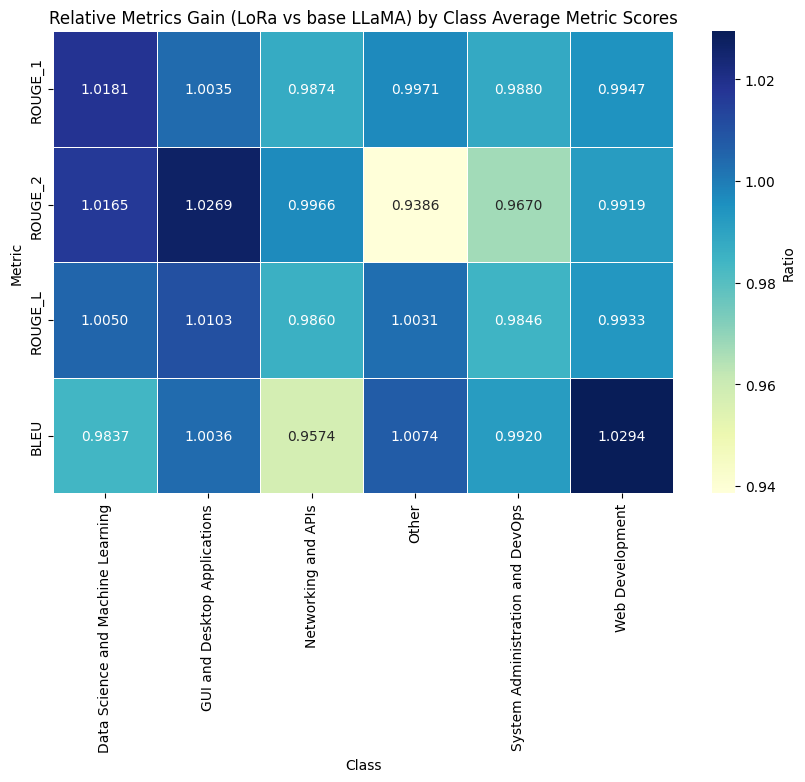

In [6]:
compare_metrucs(dfs_adapter, dfs_pretrain)

In [17]:
print(dfs_adapter[0].iloc[3,0])

Recently, I've been interested in Data analysis.
So I researched about how to do machine-learning project and do it by myself.
I learned that scaling is important in handling features.
So I scaled every features while using Tree model like Decision Tree or LightGBM.
Then, the result when I scaled had worse result.
I searched on the Internet, but all I earned is that Tree and Ensemble algorithm are not sensitive to variance of the data. 
I also bought a book "Hands-on Machine-learning" by O'Relly But I couldn't get enough explanation.
Can I get more detailed explanation for this?


In [15]:
print(dfs_adapter[0].iloc[3,-5])

Tree-based algorithms will ignore the scaling of features in the algorithm itself. But they are still sensitive the distribution of your feature data, which you can learn by looking at the tree itself (e.g. the impurity/entropy of each node).
In contrast, other machine learning algorithms, like KNN, are sensitive. Scaling can improve the performance of KNn.


In [16]:
print(dfs_pretrain[0].iloc[3,-5])

Tree-based algorithms will ignore the scaling of features in the algorithm itself. But they are still sensitive the distribution of your feature data, which you can learn by looking at the tree itself (e.g. check the leaves and their distribution).
However, it is still important to scale your data before you feed it to the machine learning algorithm. This is because the results of an algorithm can be quite sensitive (or not) to feature scales. So you should scale the features as a preprocessing step, before feeding the scale to your algorithm (i.e., you have to rescale the dataset in between).
